Loading and preprocessing data...
Data loading and preprocessing took 0.34 seconds

=== Task 1: Predictive Modeling ===

Training and evaluating Linear Regression:
RMSE: 1.3759
MAE: 1.1453
R² Score: 0.1683
Model training and evaluation took 0.04 seconds

Training and evaluating Decision Tree:
Best parameters found: {'model__max_depth': 5}
RMSE: 0.3272
MAE: 0.2159
R² Score: 0.9530
Model training and evaluation took 4.65 seconds

Training and evaluating Random Forest:
Best parameters found: {'model__max_depth': 10, 'model__n_estimators': 200}
RMSE: 0.3071
MAE: 0.2014
R² Score: 0.9586
Model training and evaluation took 17.42 seconds

Training and evaluating Gradient Boosting:
Best parameters found: {'model__learning_rate': 0.1, 'model__n_estimators': 100}
RMSE: 0.3102
MAE: 0.2065
R² Score: 0.9577
Model training and evaluation took 3.31 seconds

=== Task 2: Customer Preference Analysis ===
Cuisine preference analysis took 0.10 seconds

Top 10 Cuisines by Average Rating:
                 Av

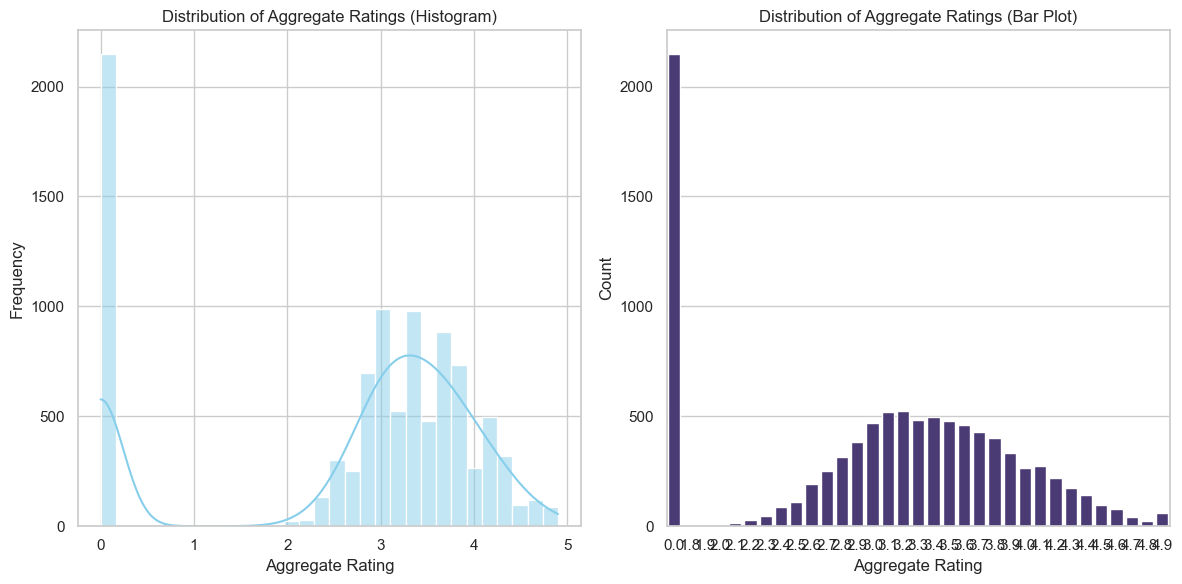

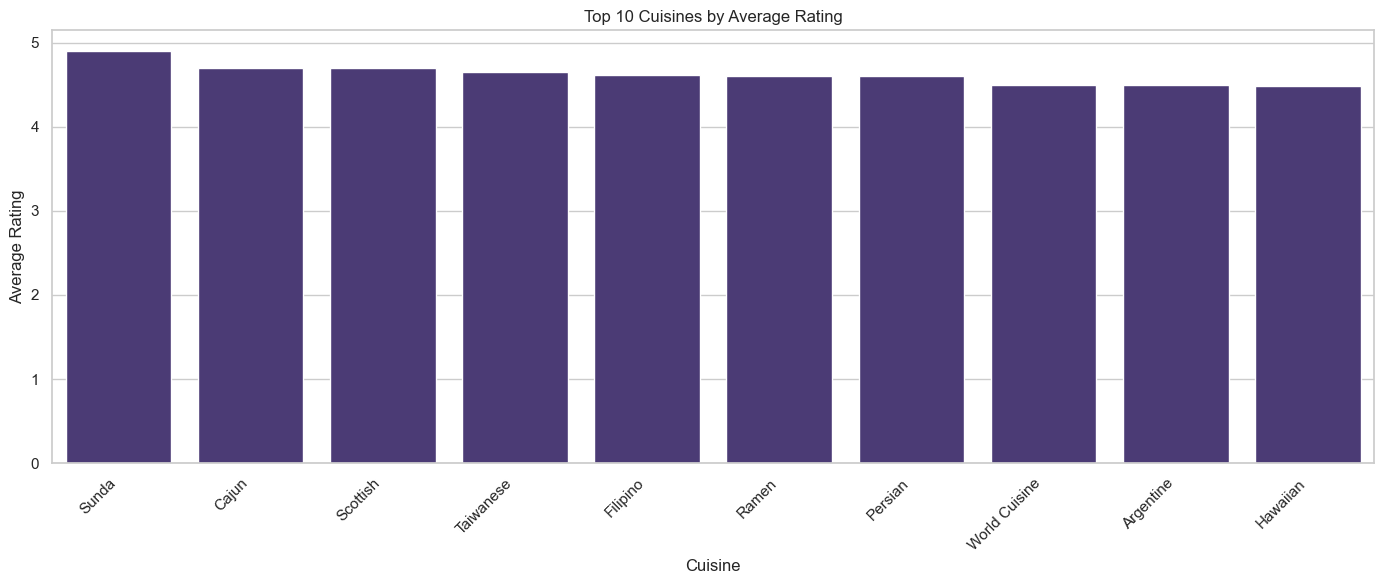

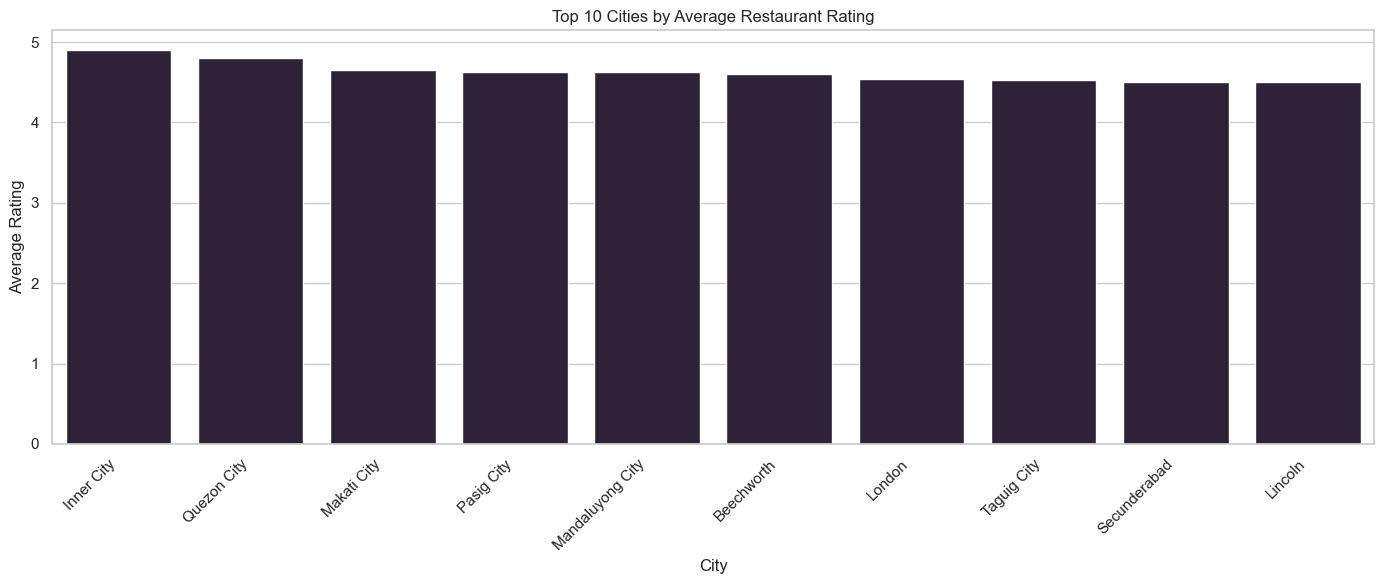

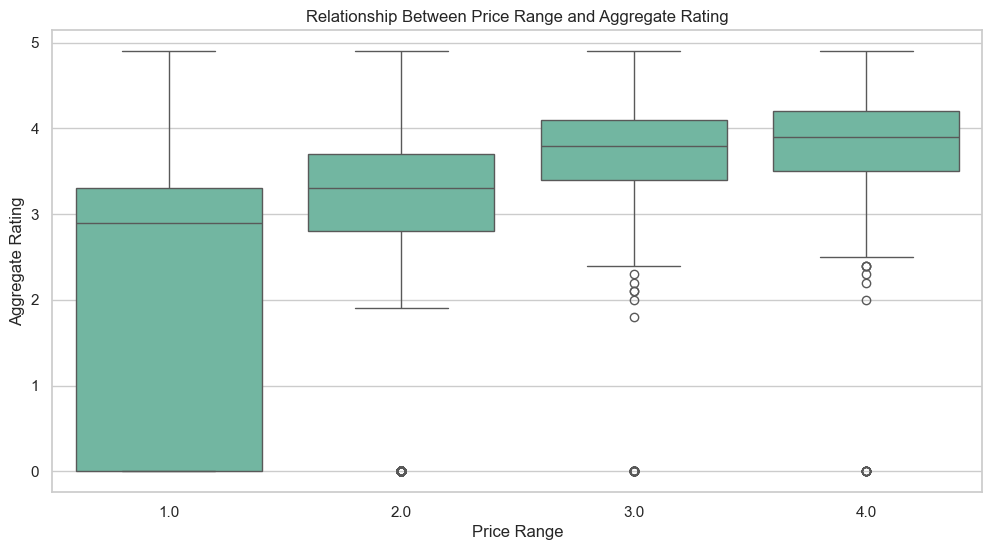

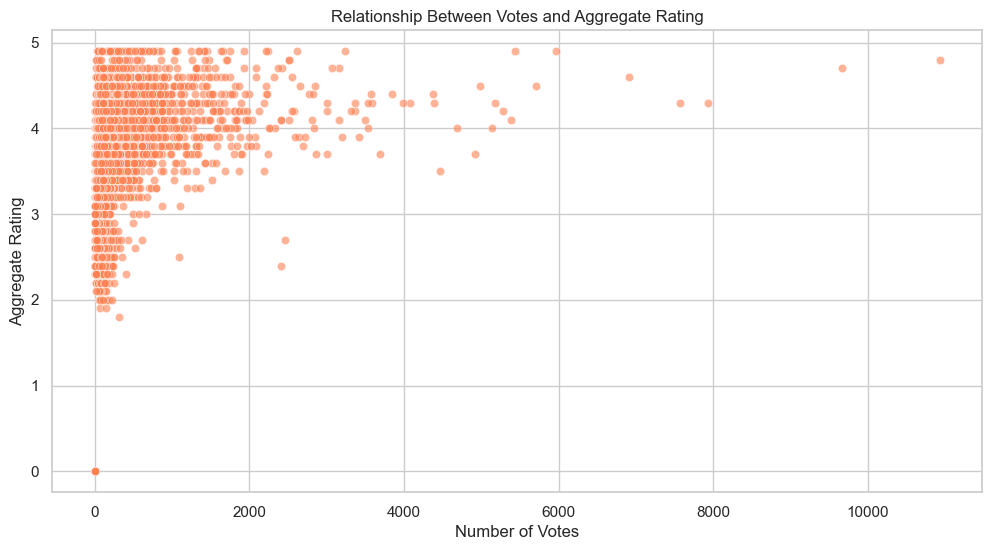

Visualizations took 2.89 seconds


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import time  # For benchmarking

# Configure plot settings
plt.style.use('default')
sns.set_theme(style="whitegrid")

file_path = r"C:\Users\morah\OneDrive\Desktop\c\ds.csv"

def load_and_preprocess_data(file_path):
    start_time = time.time()
    
    # Load the dataset with explicit data types to potentially save memory and speed up loading
    #This will need to be adjusted based on your specific file.
    #dtypes = {'Votes': 'int32', 'Aggregate rating': 'float32', 'Price range': 'int8'}
    df = pd.read_csv(file_path)#, dtype=dtypes)

    # Remove all-null columns
    df.dropna(axis=1, how='all', inplace=True)
    
    # Handle binary categorical variables more robustly (vectorized mapping)
    binary_cols = ['Has Table booking', 'Has Online delivery', 'Is delivering now']
    for col in binary_cols:
        if col in df.columns:
            df[col] = df[col].map({'Yes': 1, 'No': 0}).astype(float)
    
    # Extract and encode cuisines
    df['Cuisines'] = df['Cuisines'].fillna('Unknown')
    df['Primary_Cuisine'] = df['Cuisines'].apply(lambda x: str(x).split(',')[0].strip())
    

    # Preserve the 'City' and 'Price range' column before get_dummies
    city_column = df['City'].copy()
    price_range_column = df['Price range'].copy()

    # Create dummies for categorical variables
    categorical_cols = ['Country Code', 'City', 'Primary_Cuisine']  # Exclude 'Price range' here
    df = pd.get_dummies(df, columns=categorical_cols, dummy_na=False)  # Explicitly handle NaN in dummies

    # Add the original 'City' and 'Price range' column back after one-hot encoding
    df['City'] = city_column
    df['Price range'] = price_range_column
    
    # Ensure 'Price range' is numeric *after* adding it back
    df['Price range'] = pd.to_numeric(df['Price range'], errors='coerce')

    # Handle missing values in numeric columns using SimpleImputer
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    imputer = SimpleImputer(strategy='mean')
    df[numeric_cols] = imputer.fit_transform(df[numeric_cols])
    
    # Ensure all columns are numeric
    non_numeric_cols = df.select_dtypes(exclude=['float64', 'int64']).columns
    for col in non_numeric_cols:
        if col not in ['Restaurant ID', 'Restaurant Name', 'Address', 'Locality', 
                      'Locality Verbose', 'Cuisines', 'Currency', 'Rating color', 
                      'Rating text', 'City']:  # Keep 'City' column
            try:
                df[col] = pd.to_numeric(df[col], errors='coerce')
            except:
                print(f"Warning: Could not convert column {col} to numeric. Dropping Column")
                df.drop(columns=[col], inplace=True) #Using inplace to avoid creating unnecessary copies.
    

    end_time = time.time()
    print(f"Data loading and preprocessing took {end_time - start_time:.2f} seconds")
    return df

def create_model_pipeline(model):
    # Create a pipeline that includes scaling and the model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Standardize features
        ('model', model)  # Your chosen model
    ])
    return pipeline

def train_and_evaluate_model(X_train, X_test, y_train, y_test, model, param_grid=None):
    start_time = time.time()
    
    #Create a pipeline
    pipeline = create_model_pipeline(model)
    
    #Hyperparameter tuning using GridSearchCV
    if param_grid:
        grid_search = GridSearchCV(pipeline, param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        print("Best parameters found:", grid_search.best_params_)
        model = grid_search.best_estimator_
    else:
        model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R² Score: {r2:.4f}")
    
    end_time = time.time()
    print(f"Model training and evaluation took {end_time - start_time:.2f} seconds")
    
    return model, {'RMSE': rmse, 'MAE': mae, 'R2': r2}
    
def evaluate_models(X_train, X_test, y_train, y_test):
    results = {}
    trained_models = {}

    #Define models and parameter grids
    models = {
        'Linear Regression': (LinearRegression(), {}),
        'Decision Tree': (DecisionTreeRegressor(random_state=42),
                          {'model__max_depth': [5, 10, 15]}),  # Example parameter grid
        'Random Forest': (RandomForestRegressor(random_state=42),
                          {'model__n_estimators': [50, 100, 200], 'model__max_depth': [None, 5, 10]}),
        'Gradient Boosting': (GradientBoostingRegressor(random_state=42),
                           {'model__n_estimators': [50, 100], 'model__learning_rate': [0.01, 0.1]}) # Example Grid
    }
    
    for name, (model, param_grid) in models.items():
        print(f"\nTraining and evaluating {name}:")
        trained_model, metrics = train_and_evaluate_model(X_train, X_test, y_train, y_test, model, param_grid)
        results[name] = metrics
        trained_models[name] = trained_model
        
    return results, trained_models
    

def analyze_cuisine_preferences(df):
    start_time = time.time()
    # Get original cuisine names before one-hot encoding
    original_df = pd.read_csv(file_path)
    original_df['Primary_Cuisine'] = original_df['Cuisines'].fillna('Unknown').apply(
        lambda x: str(x).split(',')[0].strip()
    )
    
    # Aggregate cuisine ratings
    cuisine_stats = original_df.groupby('Primary_Cuisine').agg({
        'Aggregate rating': ['mean', 'count', 'std'],
        'Votes': 'sum'
    }).round(2)
    
    cuisine_stats.columns = ['Avg_Rating', 'Restaurant_Count', 'Rating_Std', 'Total_Votes']
    cuisine_stats = cuisine_stats.sort_values('Total_Votes', ascending=False)
    
    end_time = time.time()
    print(f"Cuisine preference analysis took {end_time - start_time:.2f} seconds")
    return cuisine_stats

def create_visualizations(df, results, cuisine_stats):
    start_time = time.time()
    # 1. Distribution of Aggregate Ratings
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(df['Aggregate rating'], bins=30, kde=True, color='skyblue')
    plt.title('Distribution of Aggregate Ratings (Histogram)')
    plt.xlabel('Aggregate Rating')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 2, 2)
    rating_counts = df['Aggregate rating'].value_counts().sort_index()
    sns.barplot(x=rating_counts.index, y=rating_counts.values,  color=sns.color_palette('viridis')[0]) #Fixed by removing Pallette
    plt.title('Distribution of Aggregate Ratings (Bar Plot)')
    plt.xlabel('Aggregate Rating')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
    
    # 2. Compare Average Ratings of Different Cuisines
    top_cuisines = cuisine_stats.nlargest(10, 'Avg_Rating')
    plt.figure(figsize=(14, 6))
    sns.barplot(x=top_cuisines.index, y=top_cuisines['Avg_Rating'],  color=sns.color_palette('viridis')[0])  #Fixed by removing Pallette
    plt.title('Top 10 Cuisines by Average Rating')
    plt.xlabel('Cuisine')
    plt.ylabel('Average Rating')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    if 'City' in df.columns:
        # Average ratings of different cities
        city_stats = df.groupby('City')['Aggregate rating'].mean().sort_values(ascending=False).head(10)
        plt.figure(figsize=(14, 6))
        sns.barplot(x=city_stats.index, y=city_stats.values,  color=sns.color_palette('mako')[0])  #Fixed by removing Pallette
        plt.title('Top 10 Cities by Average Restaurant Rating')
        plt.xlabel('City')
        plt.ylabel('Average Rating')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    
    if 'Price range' in df.columns:
        # Ensure 'Price range' is numeric before creating the boxplot
        df['Price range'] = pd.to_numeric(df['Price range'], errors='coerce')
        # Drop rows where 'Price range' is NaN to avoid issues with the boxplot
        df_cleaned = df.dropna(subset=['Price range'])
        
        if not df_cleaned.empty:  # Ensure there is data after dropping NaN values
            # Example 2: Price Range vs. Aggregate Rating
            plt.figure(figsize=(12, 6))
            sns.boxplot(x='Price range', y='Aggregate rating', data=df_cleaned, color = sns.color_palette('Set2')[0]) #Fixed by removing Pallette
            plt.title('Relationship Between Price Range and Aggregate Rating')
            plt.xlabel('Price Range')
            plt.ylabel('Aggregate Rating')
            plt.show()
        else:
            print("Warning: No valid data to create boxplot for Price Range vs. Aggregate Rating.")
    
    # 3. Visualize Relationship Between Features and Target Variable
    # Example 1: Votes vs. Aggregate Rating
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='Votes', y='Aggregate rating', data=df, alpha=0.6, color='coral')
    plt.title('Relationship Between Votes and Aggregate Rating')
    plt.xlabel('Number of Votes')
    plt.ylabel('Aggregate Rating')
    plt.show()
    
    end_time = time.time()
    print(f"Visualizations took {end_time - start_time:.2f} seconds")

def main():
    # Load and preprocess data
    print("Loading and preprocessing data...")
    df = load_and_preprocess_data(file_path)
    
    # Prepare features and target, dropping non-numerical columns
    feature_cols = [col for col in df.columns if col not in ['Aggregate rating', 'Restaurant ID', 
                                                            'Restaurant Name', 'Address', 'Locality', 
                                                            'Locality Verbose', 'Cuisines', 'Currency', 
                                                            'Rating color', 'Rating text', 'City', 'Price range']]  # Exclude 'City' and 'Price range'
    X = df[feature_cols].select_dtypes(include=[np.number])
    y = df['Aggregate rating']
    
    # Drop NaN values. This is not ideal, but guarantees it runs
    X = X.dropna(axis=1, how='any')
    y = y.dropna(axis=0, how='any')
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train and evaluate models
    print("\n=== Task 1: Predictive Modeling ===")
    results, trained_models = evaluate_models(X_train, X_test, y_train, y_test)
    
    # Task 2: Customer Preference Analysis
    print("\n=== Task 2: Customer Preference Analysis ===")
    cuisine_stats = analyze_cuisine_preferences(df)
    print("\nTop 10 Cuisines by Average Rating:")
    print(cuisine_stats.nlargest(10, 'Avg_Rating')[['Avg_Rating', 'Restaurant_Count', 'Total_Votes']])
    
    # Task 3: Visualizations
    print("\n=== Task 3: Creating Visualizations ===")
    create_visualizations(df, results, cuisine_stats)

if __name__ == "__main__":
    main()

